In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

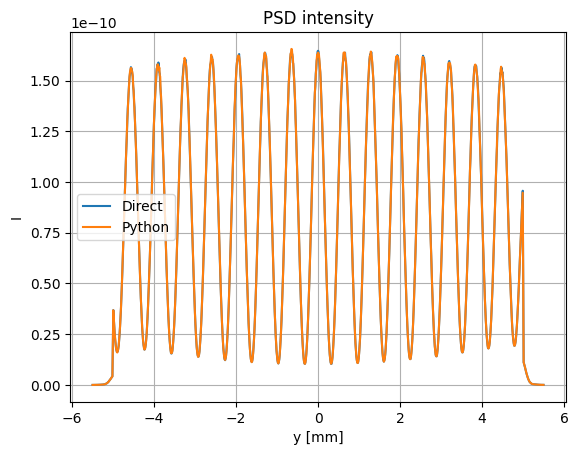

In [20]:
y, I_direct = np.genfromtxt('data/py_sample_analyser.dat', delimiter=' ', usecols=(0,1), unpack=True)
_, I_py = np.genfromtxt('data/direct_sample_analyser.dat', delimiter=' ', usecols=(0,1), unpack=True)


y*=1e-2

plt.plot(y*1e3, I_direct,'-',  label='Direct')
plt.plot(y*1e3, I_py, label='Python')

plt.xlabel('y [mm]')
plt.ylabel('I')
plt.title('PSD intensity')
plt.grid(True)  # Add grid
plt.legend()
plt.show()

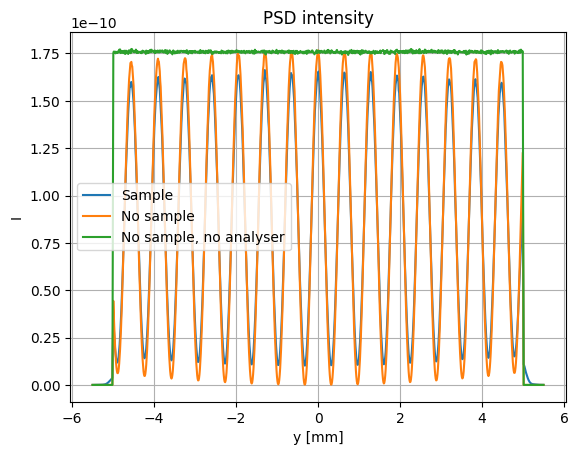

In [23]:
y_flat, I_flat = np.genfromtxt('PSD_no_mod_no_sample.dat', delimiter=' ', usecols=(0,1), unpack=True)
y, I = np.genfromtxt('PSD_mod_no_sample.dat', delimiter=' ', usecols=(0,1), unpack=True)
y_sample, I_sample = np.genfromtxt('PSD.dat', delimiter=' ', usecols=(0,1), unpack=True)


y_sample*=1e-2
y*=1e-2
y_flat*=1e-2

plt.plot(y_sample*1e3, I_sample,'-',  label='Sample')
plt.plot(y*1e3, I, label='No sample')
plt.plot(y_flat*1e3, I_flat,  label='No sample, no analyser')

plt.xlabel('y [mm]')
plt.ylabel('I')
plt.title('PSD intensity')
plt.grid(True)  # Add grid
plt.legend()
plt.show()

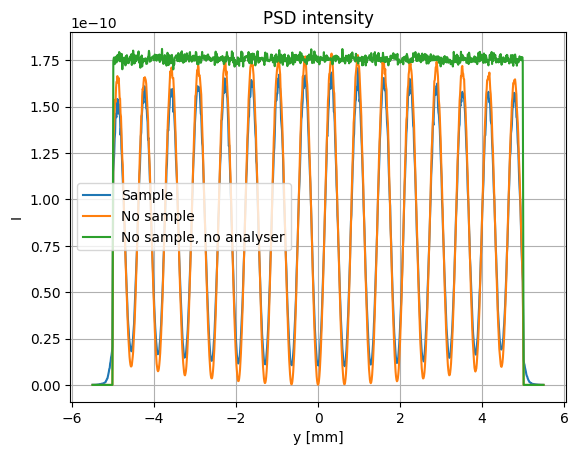

In [19]:
y_flat, I_flat = np.genfromtxt('SEMSANS_Delft_data/no-sample-no-pol.dat', delimiter=' ', usecols=(0,1), unpack=True)
y, I = np.genfromtxt('SEMSANS_Delft_data/pol.dat', delimiter=' ', usecols=(0,1), unpack=True)
y_sample, I_sample = np.genfromtxt('SEMSANS_Delft_data/sample-pol.dat', delimiter=' ', usecols=(0,1), unpack=True)


y_sample*=1e-2
y*=1e-2
y_flat*=1e-2

plt.plot(y_sample*1e3, I_sample,'-',  label='Sample')
plt.plot(y*1e3, I, label='No sample')
plt.plot(y_flat*1e3, I_flat,  label='No sample, no analyser')

plt.xlabel('y [mm]')
plt.ylabel('I')
plt.title('PSD intensity')
plt.grid(True)  # Add grid
plt.legend()
plt.show()

# Estimate of $p_0$ and $Z$
$$p_0 = \frac{\pi\tan{\theta_0}}{c\lambda(B_2-B_1)}$$
$$z = \frac{c\lambda^2(B_2-B_1)L}{\pi\tan{\theta_0}}$$

In [29]:
c = 4.63e14 # T-1 m-2
theta_0 = np.deg2rad(5.5) # rad
wavelength = 2.165e-10 # m
def compute_p_0(By):
    delta_B = By
    p_0 = np.pi * np.tan(theta_0) / (c * wavelength * delta_B)
    return p_0

def compute_z(By):
    # B_2 - B_1 generally
    delta_B = By
    # Distance between centers of the 2 flippers
    L = 2 # m
    z = c * wavelength ** 2 * delta_B * L / (np.pi * np.tan(theta_0))
    return z

In [35]:
def indices_within_range(x, a, b):
    return np.where((x >= a) & (x <= b))[0]

def I_fit(y, a, b, p_inv, phi):
    return (a + b * np.cos(2*np.pi * y * p_inv+phi))

def I_mod(y, I_0, A, p_0, phi):
    return I_0 * (1 + A * np.cos(2*np.pi * y / p_0+phi))

def fit_pattern(y, I, By, plot=False):
    p_0_pred = compute_p_0(By)
    p_inv = 1/p_0_pred
    indices = indices_within_range(y, -0.005, 0.005)

    # The DC component can be expected to be the mean
    mean = np.mean(I[indices])
    # The amplitude will be roughly the max minus the mean
    amplitude = np.max(I[indices]) - mean

    # bounds = ([0.7 * mean, 0.7 * amplitude, 0.8*p_inv,0.0], [1.3 * mean, 1.3 * amplitude, 1.2*p_inv,2*np.pi])
    guess =  [mean, amplitude, p_inv, 0]
    popt, pcov = curve_fit(I_fit, y[indices], I[indices],p0=guess)
    I_0 = popt[0]
    diag = np.diagonal(pcov)
    dI_0 = diag[0]
    A_0 = popt[1] / popt[0]
    dA_0 = np.sqrt((popt[1]*diag[0]/popt[0]**2)**2+diag[1]**2)
    p_0_fit = 1/popt[2]
    dp_0_fit = diag[2] / popt[2]**2
    phi = popt[3]
    dphi = diag[3]
    I_0, A_0, p_0_fit
    if plot:    
        I_fitted = I_mod(y[indices],*[I_0, A_0, p_0_fit,phi])
        I_guess = I_mod(y[indices],*[mean, amplitude/mean, 1/p_inv,phi])
        plt.plot(y*1e3, I, '.', label='Simulation data')
        plt.plot(y[indices]*1e3, I_fitted, label='Fit')
        plt.plot(y[indices]*1e3, I_guess, label='Guess')
        plt.xlabel('y [mm]')
        plt.ylabel('I')
        plt.grid(True)
        plt.legend()
        plt.show()
    return [I_0,A_0,p_0_fit, phi], [dI_0,dA_0,dp_0_fit, dphi]

$\frac{A(z)}{A_0} = e^{s_t(G(z)-1)}$

In [36]:
s_t = 0.38 # for the specified sample, see 2021 sim paper
G_z = np.log(R) / s_t + 1
G_z

NameError: name 'R' is not defined

In [43]:
import re

def extract_By(file):
    with open(file) as f:
        text = f.read()
        match = re.search(r'# Param: By=([0-9.]+)', text)
        assert(match)
        return float(match.group(1))

for i in range(0,21):
    By = extract_By(f"SEMSANS_Delft_20240429_175314/{i}/det.dat")
    z = compute_z(By)
    print(By,z)
    y, I = np.genfromtxt(f"SEMSANS_Delft_20240429_175314/{i}/det.dat", delimiter=' ', usecols=(0,1), unpack=True)
    y *= 1e-2
    params, dparams = fit_pattern(y,I,By, False)
    A_z = params[1]
    dA_z = dparams[1]
    print(A_z, dA_z)
    # params, dparams = fit_pattern(y,I,True)
    # params_sample, dparams_sample = fit_pattern(y_sample,I_sample,True)
    # A_0 = params[1]
    # dA_0 = dparams[1]
    # A_z = params_sample[1]
    # dA_z = dparams_sample[1]
    # R = A_z/A_0 
    # dR = np.sqrt(dA_z**2 + (A_z*dA_0/A_0**2)**2)
    # R, dR    
    # y_sample, I_sample = np.genfromtxt('SEMSANS_Delft_data/sample-pol.dat', delimiter=' ', usecols=(0,1), unpack=True)


0.0 0.0
-0.9953086776152257 inf
0.00156 2.2383325996334172e-07
0.9752559318849279 1.0129884876248517e-16
0.00312 4.4766651992668344e-07
0.9109306437493212 4.805468259866473e-16
0.00468 6.714997798900252e-07
0.8358823621796864 7.133112170562079e-16
0.00624 8.953330398533669e-07
0.7550892436444792 9.35013310249881e-16
0.0078 1.1191662998167086e-06
0.6707838120277216 1.2317418015959146e-15
0.00936 1.3429995597800503e-06
0.6017925920898977 1.1489014098947925e-15
0.01092 1.5668328197433918e-06
0.5327439523559115 1.338829316193372e-15
0.01248 1.7906660797067337e-06
0.48558075336154516 1.1966118302618413e-15
0.01404 2.0144993396700752e-06
0.44243973656895025 1.2762164192566531e-15
0.0156 2.238332599633417e-06
0.4083650375986232 1.2345740151661473e-15
0.01716 2.462165859596759e-06
0.37967197345141224 1.201298629631807e-15
0.01872 2.6859991195601006e-06
0.34794280225562807 1.1868922459757383e-15
0.02028 2.909832379523442e-06
0.32818444684683074 1.0912643904793514e-15
0.02184 3.1336656394867836e

/tmp/ipykernel_18215/345779079.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  p_0 = np.pi * np.tan(theta_0) / (c * wavelength * delta_B)
/tmp/ipykernel_18215/1817802287.py:22: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(I_fit, y[indices], I[indices],p0=guess)
/tmp/ipykernel_18215/1817802287.py:28: RuntimeWarning: divide by zero encountered in scalar divide
  p_0_fit = 1/popt[2]
